# Introduction to numerical robotics

This notebook is a general introduction to Pinocchio. It shows how to manipulate the geometry model of a robot manipulator: set the configuration, compute the position of the end effector, check for collisions or the distance to an obstacle. The main idea is to give a brief introduction of the general topic: how to discover and learn a robot movement constrained by the environment, using iterative optimization methods.


In [9]:
import magic_donotload

## Set up

Let us load the UR5 robot model, the Pinocchio library, some optimization functions from SciPy and the Matplotlib for plotting:

In [ ]:
import pinocchio as pin
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
import time
import numpy as np
from numpy.linalg import norm
from scipy.optimize import fmin_slsqp
from utils.load_ur5_with_obstacles import load_ur5_with_obstacles, Target
import matplotlib.pylab as plt

Let's first load the robot model and display it. For this tutorial, a single utility function will load the robot model and create obstacles around it:

In [7]:
robot = load_ur5_with_obstacles(reduced=True)

The next few lines initialize a 3D viewer.

In [128]:
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [133]:
hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

The robot and the red obstacles are encoded in the `robot` object (we will not look in depth at what is inside this object). You can display a new configuration of the robot with `viz.display`. It takes a `numpy.array` of dimension 2 as input:

In [134]:
viz.display(np.array([-1.,-.5]))

We also set up a target with is visualized as a green dot:

In [18]:
target_pos = np.array([.5,.5])
target = Target(viz,position = target_pos)

The `Target` object is the green dot that the robot should reach. You can change the target position by editing `target.position`, and display the new position with `target.display()`.

In [23]:
target.position = np.array([.5,.6])
target.display()

## Using the robot model
The robot is originally a 6 degrees-of-freedom (DOF) manipulator. Yet to make the example simple, we will only use its joints 1 and 2. The model has simply be loaded with "frozen" extra joints, which will then not appear in this notebook. Reload the model with `reduced=False` if you want to recover a model with full DOF.

The following function computes the position of the end effector (in 2d):

In [26]:
def endef(q):
     '''Return the 2d position of the end effector.'''
     pin.framesForwardKinematics(robot.model, robot.data, q)
     return robot.data.oMf[-1].translation[[0, 2]]

This function checks if the robot is in collision, and returns `True` if a collision is detected.

In [27]:
def coll(q):
     '''Return True if in collision, false otherwise.'''
     pin.updateGeometryPlacements(robot.model, robot.data, robot.collision_model, robot.collision_data, q)
     return pin.computeCollisions(robot.collision_model, robot.collision_data, False)


The next function computes the distance between the end effector and the target.

Your code:

In [28]:
def dist(q):
     '''Return the distance between the end effector end the target (2d).'''
     ee_pos = endef(q)
     return norm(ee_pos - target.position)


## Random search of a valid configuration
The free space is difficult to represent explicitly. We can sample the configuration space until a free configuration is found:

In [29]:
def qrand(check=False):
    '''Return a random configuration. If `check` is True, this configuration is not in collision.'''
    while True:
        q = np.random.rand(2)*6.4 - 3.2
        if not check or not coll(q):
            return q

In [34]:
viz.display(qrand(check=True))

Let's now find a valid configuration that is arbitrarily close to the target: sample until dist is small enough and coll is false (you may want to display the random trials inside the loop).

In [ ]:
def close_valid_config():
    '''Return a random configuration close to the target and not in collision.'''
    while True:
        q = qrand(check=False)
        if dist(q) < 0.5 and not coll(q):
            return q

In [70]:
viz.display(close_valid_config())

## From a random configuration to the target
Let' s now start from a random configuration. How can we find a path that bring the robot toward the target without touching the obstacles. Any idea?

In [94]:
# Random descent: crawling from one free configuration to the target with random
# steps.
def randomDescent(q0 = None):
     '''
     Make a random walk of 0.1 step toward target
     Return the list of configurations visited
     '''
     q = close_valid_config() if q0 is None else q0
     hist = [q.copy()]
     for _ in range(500):
          viz.display(q)
          time.sleep(0.05)
          step = 0.1 * (qrand() - q)
          qnew = q + step
          if not coll(qnew) and dist(qnew) < dist(q):
               q = qnew
               hist.append(q.copy())
          if dist(q) < 0.02:
               break
     return np.array(hist)

*Clue:*
- *Use a random walk sampling random direction to extend*
- *Bias the walk toward the goal by keeping the extension only if it is closer to the goal*

And solution if needed

In [ ]:
%load tp0/generated/simple_path_planning_random_descent

In [82]:
randomDescent()

[array([-1.30014353, -0.42775849]),
 array([-0.93987534, -0.4732149 ]),
 array([-1.04328783, -0.20557598]),
 array([-1.14241427, -0.00531016]),
 array([-1.01389853,  0.0672793 ]),
 array([-0.8527676 , -0.10018659]),
 array([-0.85895018, -0.06683599]),
 array([-0.97365127,  0.23131584]),
 array([-0.9798083,  0.2131101]),
 array([-1.03813014,  0.35343977]),
 array([-1.1127874 ,  0.47085707]),
 array([-1.2361056 ,  0.64404032]),
 array([-1.3071643 ,  0.74437573]),
 array([-1.2864195 ,  0.78027939])]

## Configuration space
Let's try to have a better look of the configuration space. In this case, it is easy, as it is dimension 2: we can sample it exhaustively and plot it in 2D. For that, let's introduce another function to compute the distance to collision:

In [85]:
def collisionDistance(q):
     '''Return the minimal distance between robot and environment. '''
     pin.updateGeometryPlacements(robot.model,robot.data,robot.collision_model,robot.collision_data,q)
     if pin.computeCollisions(robot.collision_model,robot.collision_data,False):
         return 0.0
     idx = pin.computeDistances(robot.collision_model,robot.collision_data)
     return robot.collision_data.distanceResults[idx].min_distance

Now, let's sample the configuration space and plot the distance-to-target and the distance-to-obstacle field (I put 500 samples to spare your CPU, but you need at least 10x more for obtaining a good picture).

In [86]:
def sampleSpace(nbSamples=500):
     '''
     Sample nbSamples configurations and store them in two lists depending
     if the configuration is in free space (hfree) or in collision (hcol), along
     with the distance to the target and the distance to the obstacles.
     '''
     hcol = []
     hfree = []
     for i in range(nbSamples):
          q = qrand(False)
          if not coll(q):
               hfree.append( list(q.flat) + [ dist(q), collisionDistance(q) ])
          else:
               hcol.append(  list(q.flat) + [ dist(q), 1e-2 ])
     return hcol,hfree

def plotConfigurationSpace(hcol,hfree,markerSize=20):
     '''
     Plot 2 "scatter" plots: the first one plot the distance to the target for 
     each configuration, the second plots the distance to the obstacles (axis q1,q2, 
     distance in the color space).
     '''
     htotal = hcol + hfree
     h=np.array(htotal)
     plt.subplot(2,1,1)
     plt.scatter(h[:,0],h[:,1],c=h[:,2],s=markerSize,lw=0)
     plt.xlabel("$q_1$")
     plt.ylabel("$q_2$")
     plt.title("Distance to the target")
     plt.colorbar()
     plt.subplot(2,1,2)
     plt.scatter(h[:,0],h[:,1],c=h[:,3],s=markerSize,lw=0)
     plt.xlabel("$q_1$")
     plt.ylabel("$q_2$")
     plt.title("Distance to the obstacles")
     plt.tight_layout()
     plt.colorbar()

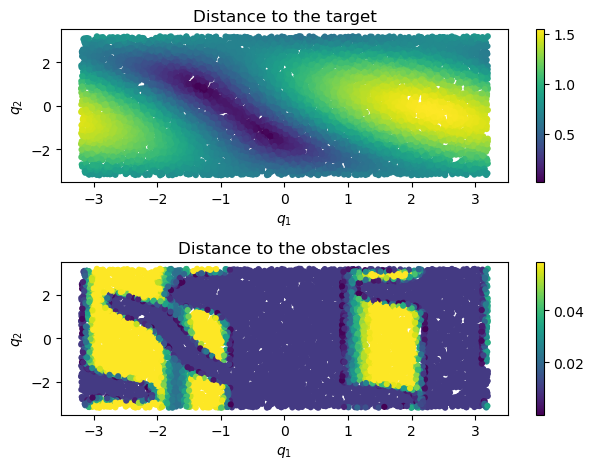

In [89]:
hcol,hfree = sampleSpace(10000)
plotConfigurationSpace(hcol,hfree)


You can try to match your representation of the free space of the robot with this plot. 
As an example, you can display on this plot a feasible trajectory discover by random walk from an init position.

In [106]:
traj = np.array([])
qinit = np.array([-2.5, -.5])

traj = randomDescent(qinit)

Here is a solution:

In [ ]:
%load tp0/generated/simple_path_planning_traj

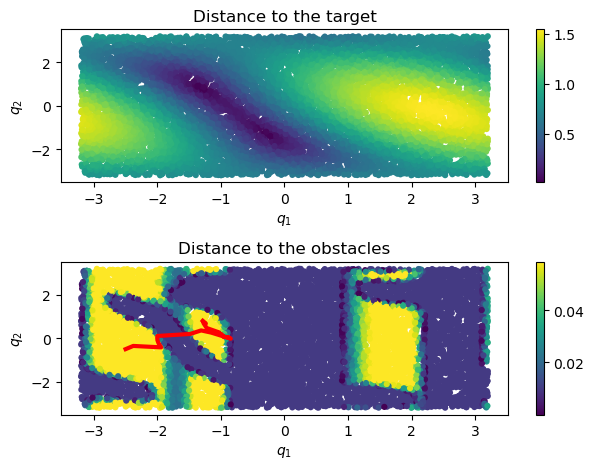

In [107]:
# Add your traj to the plot, be carefull !
plotConfigurationSpace(hcol,hfree)
plt.plot(traj[:,0],traj[:,1],'r',lw=3)

## Optimize the distance under non-collision constraint
Finally, let's use one of the optimizers from SciPy to search for a robot configuration that minimizes the distance to the target, under the constraint that the distance to collision is positive.
For that, we define a *cost function* $cost: \mathcal{C} \to \mathbb{R}$ (taking the robot configuration and returning a scalar) and a constraint function (taking again the robot configuration and returning a scalar that should be positive). We additionally use the "callback" functionnality of the solver to render the robot configuration corresponding to the current value of the decision variable inside the solver algorithm.
We use the "SLSQP" solver from SciPy, which implements a "sequential quadratic program" algorithm and accepts constraints.


The constraint is a positive distance with a margin on $\epsilon$

In [111]:
epsilon = .01

In [120]:
def cost(q):
     '''
     Cost function to minimize : distance to target
     '''
     return dist(q)**2
     
def constraint(q):
     '''
     Constraint: the distance to collision must be positive
     '''
     return collisionDistance(q) - epsilon
     
def callback(q):
     '''
     At each optimization step, display the robot configuration in gepetto-viewer.
     '''
     viz.display(q)
     time.sleep(.01)

def optimize():
     '''
     Optimize from an initial random configuration to discover a collision-free
     configuration as close as possible to the target.
     USE fmin_slsqp, see doc online
     '''
     q0 = qrand(check=False)
     return fmin_slsqp(cost, q0, f_ieqcons=constraint, callback=callback, full_output=1)

Look at the output of the solver. It always returns a variable value, but sometimes the algorithm fails being traped in an unfeasible region. Most of the time, the solver converges to a local minimum where the final distance to the target is nonzero

In [125]:
optimize()

Iteration limit reached    (Exit mode 9)
            Current function value: 2.3099732635145913e-13
            Iterations: 100
            Function evaluations: 1200
            Gradient evaluations: 100


(array([-0.28106434, -1.29730588]),
 2.3099732635145913e-13,
 100,
 9,
 'Iteration limit reached')

Now you can write a planner that try to optimize and retry until a valid solition is found!

In [132]:
# Your solution
while True:
    result = optimize()
    q = result[0]
    viz.display(q)
    if not result[4]=='Optimization terminated successfully' and result[1] < 1e-6:
        print("Optimization succeeded")
        break
    else:
        print("Optimization failed, retrying...")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.9970688904578113e-08
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 9
Optimization failed, retrying...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.034242867007218e-08
            Iterations: 11
            Function evaluations: 35
            Gradient evaluations: 11
Optimization failed, retrying...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0027155618226771e-10
            Iterations: 19
            Function evaluations: 70
            Gradient evaluations: 19
Optimization failed, retrying...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02203533905417171
            Iterations: 7
            Function evaluations: 22
            Gradient evaluations: 7
Optimization failed, retrying...
Optimization termina